In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.quantum.linear_complex import UnaryLinearComplex, LinearComplex
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def unary_linear_complex_test(rng="Sobol", in_feature=16, out_feature=16, bitwidth=8):
    mode = "bipolar"
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True, False]
    result_pe_r = []
    result_pe_i = []
    
    for scale in scaled:
        run_time = 0
        length = 2**bitwidth
        result_pe_cycle_r = []
        result_pe_cycle_i = []

        wr = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
        wi = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
        
        fc = LinearComplex(in_feature, out_feature, wr, wi).to(device)
        
        ufc = UnaryLinearComplex(in_feature, out_feature, wr, wi, 
                                 bitwidth=bitwidth, scaled=scale, 
                                 stype=stype, btype=btype, rtype=rtype).to(device)

        iVec_r = ((torch.rand(1, in_feature).mul(2).sub(1)*length).round()/length).to(device)
        iVec_i = ((torch.rand(1, in_feature).mul(2).sub(1)*length).round()/length).to(device)
        
        start_time = time.time()
        oVec_r, oVec_i = fc(iVec_r, iVec_i)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        iVecSRC_r = SourceGen(iVec_r, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
        iVecSRC_i = SourceGen(iVec_i, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)

        iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)

        iVecBS_r = BSGen(iVecSRC_r, iVecRNG, stype=stype).to(device)
        iVecBS_i = BSGen(iVecSRC_i, iVecRNG, stype=stype).to(device)
            
        iVecPE_r = ProgressiveError(iVec_r, scale=1, mode=mode).to(device)
        iVecPE_i = ProgressiveError(iVec_i, scale=1, mode=mode).to(device)
        
        if scale is True:
            oVecPE_r = ProgressiveError(oVec_r, scale=in_feature*2, mode=mode).to(device)
            oVecPE_i = ProgressiveError(oVec_i, scale=in_feature*2, mode=mode).to(device)
        else:
            oVecPE_r = ProgressiveError(oVec_r, scale=1, mode=mode).to(device)
            oVecPE_i = ProgressiveError(oVec_i, scale=1, mode=mode).to(device)
        
        with torch.no_grad():
            idx = torch.zeros(iVecSRC_r.size()).type(torch.long).to(device)
            
            for i in range(length):
                iBS_r = iVecBS_r(idx + i)
                iVecPE_r.Monitor(iBS_r)
                iBS_i = iVecBS_i(idx + i)
                iVecPE_i.Monitor(iBS_i)
                
                start_time = time.time()
                oVecU_r, oVecU_i = ufc(iBS_r, iBS_i)
                run_time = time.time() - start_time + run_time
                
                oVecPE_r.Monitor(oVecU_r)
                oVecPE_i.Monitor(oVecU_i)
                
                err_r = oVecPE_r()[1]
                rmse_r = 1-torch.sqrt(torch.mean(err_r**2)).item()
                err_i = oVecPE_i()[1]
                rmse_i = 1-torch.sqrt(torch.mean(err_i**2)).item()
                result_pe_cycle_r.append(rmse_r)
                result_pe_cycle_i.append(rmse_i)
            print("--- %s seconds ---" % (run_time))
            print("input r error: ", "min:", torch.min(iVecPE_r()[1]).item(), "max:", torch.max(iVecPE_r()[1]).item())
            print("output r error: ", "min:", torch.min(oVecPE_r()[1]).item(), "max:", torch.max(oVecPE_r()[1]).item())
            result_pe_r = oVecPE_r()[1][0].cpu().numpy()
            
            print("input i error: ", "min:", torch.min(iVecPE_i()[1]).item(), "max:", torch.max(iVecPE_i()[1]).item())
            print("output i error: ", "min:", torch.min(oVecPE_i()[1]).item(), "max:", torch.max(oVecPE_i()[1]).item())
            result_pe_i = oVecPE_i()[1][0].cpu().numpy()
            
            print("r error distribution=========>")
            plt.figure(figsize=(3,1.5))
            fig = plt.hist(result_pe_r, bins='auto')  # arguments are passed to np.histogram
            plt.title("data: "+mode+", scaled: "+str(scale))
            plt.show()
            print("r progressive accuracy=========>")
            plt.figure(figsize=(3,1.5))
            fig = plt.plot(result_pe_cycle_r)  # arguments are passed to np.histogram
            plt.title("data: "+mode+", scaled: "+str(scale))
            plt.show()
            
            print("i error distribution=========>")
            plt.figure(figsize=(3,1.5))
            fig = plt.hist(result_pe_i, bins='auto')  # arguments are passed to np.histogram
            plt.title("data: "+mode+", scaled: "+str(scale))
            plt.show()
            print("i progressive accuracy=========>")
            plt.figure(figsize=(3,1.5))
            fig = plt.plot(result_pe_cycle_i)  # arguments are passed to np.histogram
            plt.title("data: "+mode+", scaled: "+str(scale))
            plt.show()


--- 0.1599903106689453 seconds ---
--- 13.111938238143921 seconds ---
input r error:  min: -0.000244140625 max: 0.000244140625
output r error:  min: -0.0005591101944446564 max: -7.463246583938599e-05
input i error:  min: -0.000244140625 max: 0.000244140625
output i error:  min: -0.0006658956408500671 max: -0.00019600987434387207
r error distribution=========>


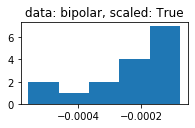

r progressive accuracy=========>


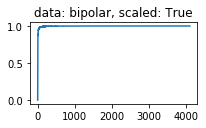

i error distribution=========>


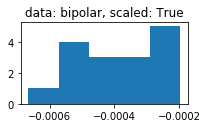

i progressive accuracy=========>


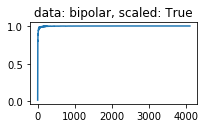

--- 0.0 seconds ---
--- 13.183039903640747 seconds ---
input r error:  min: -0.000244140625 max: 0.000244140625
output r error:  min: -0.004683852195739746 max: 0.0009765625
input i error:  min: -0.000244140625 max: 0.000244140625
output i error:  min: -0.00048828125 max: 0.006905317306518555
r error distribution=========>


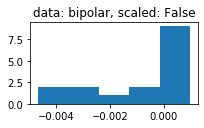

r progressive accuracy=========>


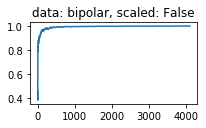

i error distribution=========>


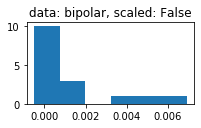

i progressive accuracy=========>


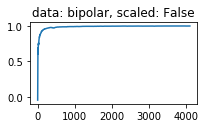

In [5]:
rng = "Sobol"
in_feature = 16
out_feature = in_feature
bitwidth = 12
unary_linear_complex_test(rng, in_feature, out_feature, bitwidth)